In [1]:
import pandas as pd
import numpy as np
from xbbg import blp
from datetime import datetime

In [2]:
DATE = '2025-02-18'
date_override = DATE.replace("-", "")

# Curves

### Legacy LIBOR Swaps

In [3]:
TICKER = 'YCSW0023 Index'
FLD = ["PAR_CURVE"]

### On/Off Run Treasuries

In [4]:
TICKER = 'YCGT0111 Index'
FLD = ["CURVE_TENOR_RATES"]

### Treasury Actives

In [5]:
TICKER = 'YCGT0025 Index'
FLD = ["CURVE_TENOR_RATES"]

### Fed Funds Swap Curve

In [6]:
TICKER = 'YCSW0042 Index'

### SOFR Swap Curve

Bloomberg's `INTEREST_RATE_CURVE_ANALYTICS` reports **continuously** compounded rates.

Use the discount factors reported and convert to rates compounded of any choice.

In [7]:
TICKER = 'YCSW0490 Index'
#FLD = ["PAR_CURVE"]
#FLD = ["CURVE_TENOR_RATES"]
FLD = ['INTEREST_RATE_CURVE_ANALYTICS']

temp = blp.bds(TICKER, FLD, REFERENCE_DATE=date_override)
quotes = temp[['date','zero_rate','discount_factor']].set_index('date').rename(columns={'zero_rate':'spot rate','discount_factor':'discount'})

In [8]:
def add_ttm(df, quote_date):
    """
    Adds a 'ttm' column to the dataframe which represents the number of years from the quote date
    to the date in the 'date' column.

    Parameters:
        df (pd.DataFrame): DataFrame containing a 'date' column.
        quote_date (str or pd.Timestamp or datetime.datetime): The reference quote date.

    Returns:
        pd.DataFrame: The augmented DataFrame with a new 'ttm' column.
    """
    # Work on a copy to avoid modifying the original dataframe
    df = df.copy()

    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Convert the quote_date to a datetime object if it isn't already
    quote_date = pd.to_datetime(quote_date)
    
    # Calculate the difference in years (using 365.25 to account for leap years)
    df['ttm'] = (df['date'] - quote_date).dt.days / 365.25

    return df

In [9]:
quotes = add_ttm(quotes.reset_index(),quote_date=DATE).set_index('ttm')

# Set Curve

In [10]:
# Parameters
interval_months = 6  # months between each interpolated date
total_years = 30     # total number of years for the new index

### Interpolate

In [11]:
from dateutil.relativedelta import relativedelta

def compute_rates(discount_factors, ttm, compounding):
    """
    Computes annualized rates from given discount factors and time-to-maturity values.
    
    Parameters:
        discount_factors (array-like): Discount factors.
        ttm (array-like): Time-to-maturity values (in years).
        compounding (int or None): 
            - If an integer, indicates the number of compounding periods per year.
            - If None, continuous compounding is assumed.
    
    Returns:
        np.ndarray: An array of annualized rates (in decimals).
    
    Notes:
        For continuous compounding:
            discount_factor = exp(-rate * ttm)
            -> rate = -ln(discount_factor) / ttm
        
        For periodic compounding:
            discount_factor = (1 + rate/compounding)**(-compounding * ttm)
            -> rate = compounding * (discount_factor**(-1/(compounding * ttm)) - 1)
    """
    discount_factors = np.array(discount_factors)
    ttm = np.array(ttm)
    
    if compounding is None:
        # Continuous compounding
        rates = -np.log(discount_factors) / ttm
    else:
        # Periodic compounding
        rates = compounding * (discount_factors ** (-1/(compounding * ttm)) - 1)
    
    return rates


def compute_discount_factors(ttm, rates, compounding):
    """
    Computes discount factors for given ttm values and rates.
    
    Parameters:
        ttm (array-like): Time-to-maturity values (in years).
        rates (array-like): Corresponding annualized rates (in decimals).
        compounding (int or None): 
            - If an integer, indicates the number of compounding periods per year.
            - If None, continuous compounding is assumed.
    
    Returns:
        np.ndarray: An array of discount factors.
    """
    ttm = np.array(ttm)
    rates = np.array(rates)
    
    if compounding is None:
        # Continuous compounding
        discounts = np.exp(-rates * ttm)
    else:
        # Periodic compounding (e.g. 2 for semiannual, 4 for quarterly)
        discounts = (1 + rates / compounding) ** (-compounding * ttm)
    
    return discounts


def interpolate_curve(df, interval_years=0.5, total_years=30, compounding=None):
    """
    Interpolates a spot rate curve derived from discount factors provided in the input DataFrame.
    The input DataFrame is expected to be indexed by time-to-maturity (ttm, in years) and to contain 
    a 'date' column and a 'discount' column.
    
    The function:
      1. Converts the discount factors to spot rates using the user-specified compounding convention.
      2. Interpolates the spot rate curve linearly over a new ttm grid.
      3. Computes new discount factors from the interpolated spot rates.
      4. Computes a new "maturity date" for each ttm using calendar arithmetic when possible.
    
    The quote_date is derived from the row with the smallest ttm value via:
         quote_date = date - (ttm * 365.25 days)
    
    Parameters:
        df (pd.DataFrame): DataFrame indexed by ttm (in years) with columns: 'date' and 'discount'.
        interval_years (float): The interval (in years) between interpolated points.
        total_years (float): The maximum ttm value to interpolate to.
        compounding (int or None): 
            - If an integer, indicates the number of compounding periods per year.
            - If None, continuous compounding is assumed.
    
    Returns:
        pd.DataFrame: A new DataFrame with columns: 'maturity date', 'spot rate', and 'discount',
                      all indexed by ttm.
    """
    # Work on a copy and ensure the 'date' column is in datetime format.
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    
    # Ensure the DataFrame index (ttm) is sorted and remove duplicates.
    df = df.sort_index()
    df = df[~df.index.duplicated(keep='first')]
    
    # Derive quote_date from the row with the smallest ttm.
    min_ttm = df.index.min()
    corresponding_date = df.loc[min_ttm, 'date']
    # Calculate quote_date: date = quote_date + (ttm * 365.25 days)
    quote_date = (corresponding_date - pd.to_timedelta(min_ttm * 365.25, unit='D')).date()
    
    # Convert input discount factors to spot rates.
    # (Assumes compute_rates is defined as in the previous example.)
    spot_rates = compute_rates(df['discount'].values, df.index.values, compounding)
    
    # Create a new ttm range.
    new_ttm = np.arange(1, int(total_years / interval_years) + 1) * interval_years
    
    # Perform linear interpolation on the spot rate curve.
    interpolated_spot = np.interp(
        new_ttm,                   # New ttm points.
        df.index.values,           # Original ttm values.
        spot_rates                 # Computed spot rates.
    )
    
    # Build the new DataFrame with interpolated spot rates.
    curve = pd.DataFrame({'spot rate': interpolated_spot}, index=new_ttm)
    curve.index.name = 'ttm'
    
    # Helper to compute the date based on ttm using calendar arithmetic when possible.
    def compute_date(ttm):
        if abs(interval_years - 0.5) < 1e-8:
            whole_years = int(ttm)
            remainder = ttm - whole_years
            if abs(remainder - 0.5) < 1e-8:
                # Half-year point: add 6 months.
                new_date = quote_date + relativedelta(years=whole_years, months=6)
            else:
                # Whole year: add full years.
                new_date = quote_date + relativedelta(years=whole_years)
        else:
            # For other intervals, approximate using 365.25 days per year.
            new_date = (pd.Timestamp(quote_date) + pd.to_timedelta(ttm * 365.25, unit='D')).date()
        return new_date

    # Compute the new "date" column for each ttm value.
    curve['date'] = [compute_date(ttm) for ttm in curve.index]
    
    # Compute new discount factors using the interpolated spot rates.
    curve['discount'] = compute_discount_factors(curve.index.values, curve['spot rate'].values, compounding)
    
    # Reorder columns to the desired order and rename 'date' to 'maturity date'.
    curve = curve.reindex(columns=["date", "spot rate", "discount"])
    curve.rename(columns={'date': 'maturity date'}, inplace=True)

    return curve

In [12]:
curve = interpolate_curve(quotes,interval_years=.25,compounding=2)

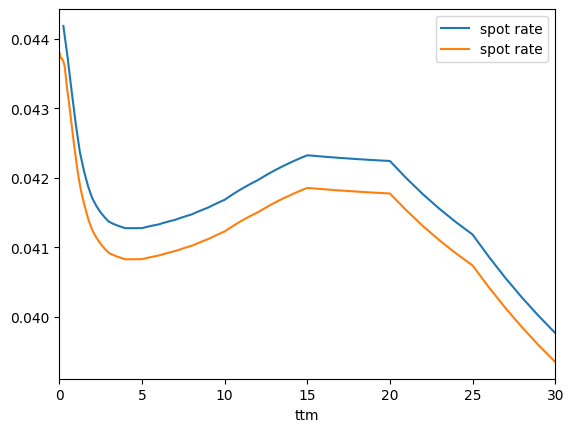

In [13]:
ax = curve[['spot rate']].plot()
quotes[['spot rate']].loc[:curve.index[-1]].plot(ax=ax)
ax.set_xlim(0,30);

***

### Save Data

In [14]:
OUTFILE = f'../data/discount_curve_{DATE}'

In [15]:
outfile = f'../data/{OUTFILE}.xlsx'
with pd.ExcelWriter(outfile) as writer:  
    curve.to_excel(writer, sheet_name= 'discount curve', index=True)